# 5.2 Training a convnet from scratch on a small dataset

## One common problem in computer vision is having to train model using little data. A 'few' samples can mean anywhere from a few hundred to a few tens of thousands of images;

## As a practical example, we will classify images as dogs or cats in a dataset containing 4000 images (2000 cats, 2000 dogs). We will use 2000 for training, 1000 for validation & 1000 for testing

## One basic strategy to tackle this problem is: train a new model from scratch using what little data you have.

### We start by naively training a small convnet on the 2000 training samples, without any regularization, to set a baseline for what can be achieved (accuracy of 71%); At this point, the main problem is overfitting, then we'll introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision (improve accuracy to 82%)

## 5.2.1 The relevance of deep learning for small-data problems

### Someone said deep learning only works when huge data is available, which is valid in part: one fundamental characteristic of deep learning is that it can find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very high-dimensional, like images.

### But that is a problem of relevance --- relative to the size and depth of the network you are trying to train. Though it is impossible to train a convnet to solve a complex problem with a few tens of samples, but a few hundred can potentially suffice if the model is small and well regularized and the task is simple 

## 5.2.2 Downloading the data

### we download the data from Kaggle 2013 competition: www.kaggle.com/c/dogs-vs-cats/data; the pictures are medium-resolution color JPEGs.
### The datasets contains 25, 000 images of dogs and cats (12,500 each) and is 543MB. We first create a new dataset containing three subsets: a training set with 2000 samples(1000 each class), a validation set with 500 samples of each class, and a test test with 500 samples of each class

In [1]:
# copy images to training, validation, and test dictionaries;
# first we set the dicionaries to contain the small image sets

import os, shutil

# path to the dictionary where the original dataset was uncompressed
original_dataset_dir = '/home/yanbo/Desktop/Chapter5/kaggle_original_data'

# dictionary where we store the small dataset later work with
base_dir = '/home/yanbo/Desktop/Chapter5/cats_and_dogs_small'
os.mkdir(base_dir)

# set dictionaries for the training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# again split the above dictionaries to dictionaries containing 2 classes: dogs and cats
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [2]:
# now we start to copy the images to pre-defined dictionaries

# copy the first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# copy the next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# last copy the next 500 images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# do the same for dogs images
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

### As a sanity check, let's count the number of pictures in each split

In [3]:
print('Total training cat images:', len(os.listdir(train_cats_dir)))

Total training cat images: 1000


In [4]:
print('Total training dog images:', len(os.listdir(train_dogs_dir)))

Total training dog images: 1000


In [5]:
print('Total validation cat images:', len(os.listdir(validation_cats_dir)))

Total validation cat images: 500


In [6]:
print('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total validation dog images: 500


In [7]:
print('Total test cat images:', len(os.listdir(test_cats_dir)))

Total test cat images: 500


In [8]:
print('Total test dog images:', len(os.listdir(test_dogs_dir)))

Total test dog images: 500


### So we do have 2000 training images, 1000 validation images and 1000 test images;
### Each split contains the same number of samples from each class: this is a *balanced binary-classification* problem, which means classification accuracy will be an appropriate measure of success

## 5.2.3  Build the network

### We use the same general structure as previous MNIST example: a stack of alternated *Conv2D* (with *relu* activation) and *MaxPooling2D* layers; 

### But because we are dealing with bigger images, we'll make the network larger, to augment the capacity of the network and to further reduce the size of the feature maps so they will not be overly huge when reaching *Flatten* layer

### Here we start from inputs of size 150 &times; 150, end up with maps of size 7 &times; 7 just before Flatten layer

### Note: The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (150 &times; 150 to 7 &times; 7), a pattern we will see almost all convnets 

In [9]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape =(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Since we are attacking a binary-classification problem, we will end up the model with a single unit (a Dense layer of size 1) and a sigmoid activation

### Let's look at the dimensions of the feature maps change with every successive layers

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

### For the compilation step, we use the 'RMSprop' optimizer as usual. Since we ended the network with a single sigmoid unit, we'll use binary crossentropy as the loss (Don't forget the cheat sheet in table 4.1)

In [11]:
from keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 5.2.4 Data preprocessing

### Currently the data sits on a drive as JPEG files, but we need to format it into appropriately preprocessed floating-point tensors before fed into the network:
### 1) Read the picture files;
### 2) Decode the JPEG content to RGB grids of pixels;
### 3) Convert these into floating-point tensors;
### 4) Rescale the pixels values (between 0 and 255) to the [0, 1] interval (as we know, neural networks prefer to deal with small input values)

### Fortunately Keras has utilities to take care of these steps automatically: the class *ImageDataGenerator* quickly sets up Python generators that can automatically turn image files to batches of preprocessed tensors

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# Rescale all images by 1 / 255
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                train_dir, # target directory
                target_size = (150, 150), # resize all images to 150 * 150 
                batch_size = 20, 
                class_mode = 'binary') # since we use binary_crossentropy, we need binary labels

validation_generator = test_datagen.flow_from_directory(
                validation_dir,
                target_size = (150, 150),
                batch_size = 20,
                class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Understanding Python generators:
### A *Python generator* is an object that acts as an iterator: it's an object you can use with the *for ... in* operator. Generators re built using the *yield* operator.

In [13]:
# we see an example of a generator that yields integers

def generator():
    i = 0
    while True:
        i += 1
        yield i
        
for item in generator():
    print(item)
    if item > 4:
        break

1
2
3
4
5


### Let's look at the output of one of these generators: it yields batches of 150 &times; 150 RGB images ( shape (20, 150, 150, 3) ) and binary labels  (shape(20, ) ). There are 20 samples in each batch.

### Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to *break* the iteration loop at some point:

In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### Let's fit the model to the data using the generator. You do this using the *fit_generator* method, the equivalent of *fit* for data generators.
### It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely. But the Keras model also needs to know how many samples to draw from the generator before declaring an epoch is over ---- which is the role of *steps_per_epoch* argument (here each batch has 20 samples, we need 100 batches until we used up 2000 samples)

### We can also pass a *validation_data* argument, it allows to accept a data generator also a tuple of Numpy arrays. Also if you pass the generator, you should specify *validation_steps* argument

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100, 
      epochs = 30,
      validation_data = validation_generator,
      validation_steps = 50)

### It's always a good practice to save the models

In [15]:
model.save('cats_and_dogs_small.h5')

### Let's plot the loss and accuracy of the model over the training and validation data during training

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### These plots are characteristics of overfitting. The training accuracy increases linearly until nearly 100%, whereas the validation accuracy stalls at 70~72%. The validation loss reaches its minimum after only 5 epochs and then stalls, whereas the training loss keeps decreasing linearly until nearly 0

### Since we have relatively few training samples (2,000), overfitting is our number-one concern. We have known several techniques mitigating overfitting, such as dropout and weight decay (L2 regularization), while now we are going to work with a new one, specific to computer vision and almost universally used whe processing images with deep-learning models: *data augmentation*

## 5.2.5 Using data augmentation

### Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit;

### Data augmentation takes the approach of generating more training data from existing training samples, by *augmenting* the samples via a number of random transformations that yield believable-looking images.

### The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

### In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the *ImageDataGenerator* instance.

In [16]:
datagen = ImageDataGenerator(
      rotation_range = 40,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

### *rotation_range*: a value in degrees (0, 180), a range within which to randomly rotate pictures
### *width_shift* and *height_shift* are ranges (a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
### *shear_range* : randomly applying shearing transformations
### *zoom_range*: randomly zooming inside pictures
### *horizontal_flip*: randomly flipping half of the images horizontally --- relevant when there are no assumptions of horizontal asymmetry
### *fill_mode*: the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

### Let's see the augmented images

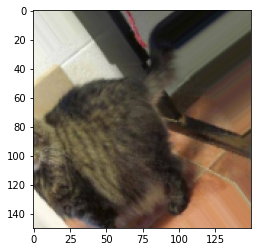

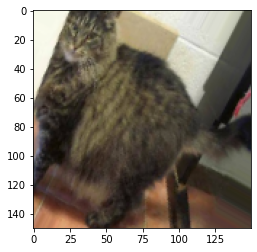

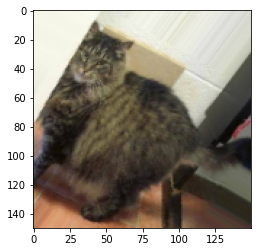

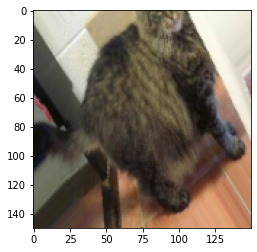

In [18]:
# display some randomly augmented training images
from keras.preprocessing import image
import matplotlib.pyplot as plt

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# choose one image to augment
img_path = fnames[3]

# read the image and resize it
img = image.load_img(img_path, target_size = (150, 150))

# convert it into a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)  # reshape to (1, 150, 150, 3)

i = 0
# generate batches of randomly transformed images
for batch in datagen.flow(x, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    
    i += 1
    if i % 4 == 0:  # loops indefinitely, need to break
        break

plt.show()

### But the inputs the network sees are still heavily intercorrelated, because they come from a small number of original images --- you cannot produce new information, you can only remix existing information; As such, this may not be enough to completely get rid of overfitting 

### To further fight overfitting, we will also add a *Dropout* layer to the model, right before the densely connected classifier

In [19]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape =(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  # add a dropout layer 
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [20]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

In [21]:
# train the convnet using data-augmentation generators
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 40,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True)

# validation data should not be augmented !! 
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
              train_dir,
              target_size = (150, 150),
              batch_size = 32,
              class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
              validation_dir,
              target_size = (150, 150),
              batch_size = 32,
              class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs = 100,
      validation_data = validation_generator,
      validation_steps = 50)

In [22]:
model.save('cats_and_dogs_small_2.h5')

### Let's plot the results again: Thanks to data augmentation and dropout, we are no longer overfitting, the training curves are closely tracking the validation curves, reaching accuracy of 82%, a 15% relative improvement over the non-regularized model

### By using regularization techniques and by tuning the hyper-parameters, we are able to get even better accuracy. But it would prove difficult to go any higher just by training your own convnet fromm scratch, because you have so little data to work with.

###  The next step to improve accuracy on this problem, we'll have to use a pre-trained model, which is the focus of the next two sections 